In [2]:
import os
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import cv2
%matplotlib widget
%load_ext autoreload
%autoreload 2
from amftrack.pipeline.functions.image_processing.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
    clean_degree_4,
)
import scipy
from amftrack.pipeline.functions.image_processing.node_id import remove_spurs
from amftrack.pipeline.functions.image_processing.extract_skel import remove_component, remove_holes
import numpy as np
from amftrack.pipeline.development.high_mag_videos.high_mag_videos_fun import *
from scipy import signal
from skimage.morphology import skeletonize
from amftrack.pipeline.functions.image_processing.extract_skel import (
    extract_skel_new_prince,
    run_back_sub,
    bowler_hat,
)
from scipy.interpolate import griddata
from PIL import Image
import pandas as pd
from scipy.optimize import curve_fit
# plt.style.use('presentation.mplstyle')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
images_path = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\FLUORESCENCE\NILE RED EXPERIMENTS - SYSTEMATIC\20221109_Plate462\DATA\20221109_Plate462_04"

# images_path = r"/mnt/sun/home-folder/cargill/20221109_Plate462/20221109_Plate462_103"
video_name = images_path.split('/')[-1]
kymos_path = '/'.join(images_path.split('/')[:-1]+["_".join((video_name,'kymos'))])
if not os.path.exists(kymos_path):
    os.mkdir(kymos_path)
files = os.listdir(images_path)
images_total_path = [os.path.join(images_path,file) for file in files]
images_total_path.sort()
fps = 20
time_pixel_size = 1/fps #s.pixel
binning = 2
magnification = 50
space_pixel_size = 2*1.725/(magnification)*binning #um.pixel

C:\Users\coren\AppData\Local\Temp\ipykernel_7416\3431719481.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[end])
C:\Users\coren\AppData\Local\Temp\ipykernel_7416\3431719481.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image2 = imageio.imread(selection_file[begin])


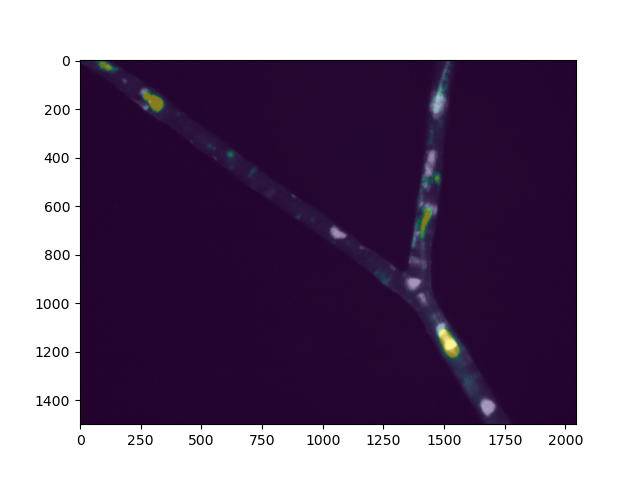

In [4]:
selection_file = images_total_path
selection_file.sort()
begin  = 1
end = -1
image = imageio.imread(selection_file[end])
image2 = imageio.imread(selection_file[begin])
selection_file = selection_file[begin:end]

fig, ax = plt.subplots()
ax.imshow(image,cmap="gray")
ax.imshow(image2,alpha = 0.5)


C:\Users\coren\AppData\Local\Temp\ipykernel_7416\1833114649.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(file) for file in selection_file[::10]]


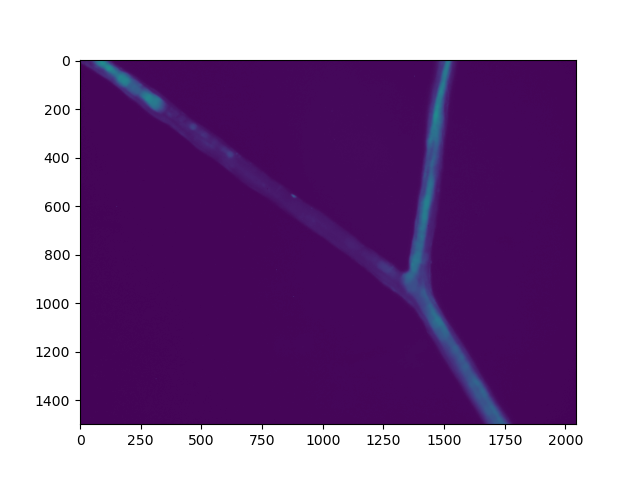

In [5]:
plt.close("all")
fig, ax = plt.subplots()
images = [imageio.imread(file) for file in selection_file[::10]]
images = [cv2.resize(image, np.flip(images[0].shape)) for image in images]
mean_proj = np.mean(np.array(images), axis=0)
# ax.imshow(mean_proj>10)
ax.imshow(mean_proj)

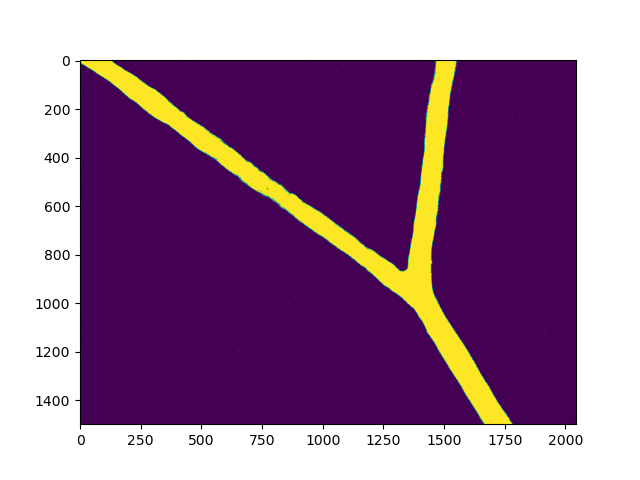

In [13]:

fig, ax = plt.subplots()
# ax.imshow(segmented)
thresh = 12
# ax.imshow(segmented)
ax.imshow(mean_proj>thresh)

In [30]:
# image = mean_proj
# smooth_im = cv2.blur(-image, (11, 11))
# thresh=0.5e-6
# frangi_range=range(120, 240, 30)
# segmented = frangi(smooth_im, frangi_range)
skeletonized = skeletonize(segmented > thresh)
# segmented,nx_graph_pruned,pos = segment_brightfield(mean_proj,thresh = 5e-07)


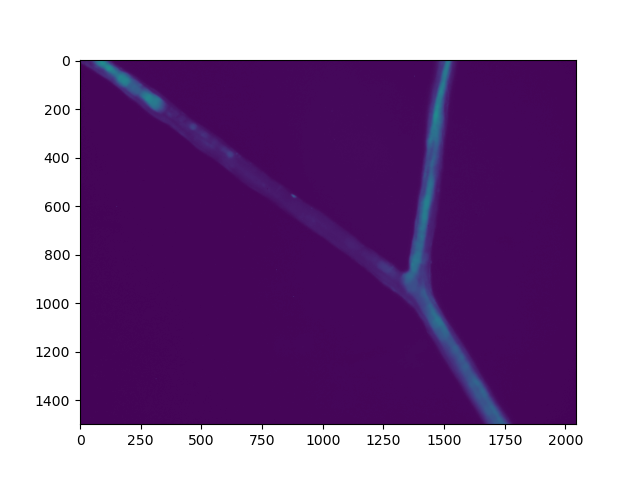

In [32]:

fig, ax = plt.subplots()
ax.imshow(image)

In [40]:
import cv2 as cv

def remove_holes(hyst):
    kernel = np.ones((10, 10), np.uint8)
    dilation = cv.dilate(hyst.astype(np.uint8) * 255, kernel, iterations=1)
    for i in range(3):
        dilation = cv.erode(dilation.astype(np.uint8) * 255, kernel, iterations=1)
        dilation = cv.dilate(dilation.astype(np.uint8) * 255, kernel, iterations=1)
    return dilation > 0

In [46]:
# segmented = frangi(image, frangi_range)
threshold = 12
segmented = mean_proj > threshold
segmented = remove_holes(segmented)
segmented = segmented.astype(np.uint8)
connected = remove_component(segmented)
skeletonized = cv2.ximgproc.thinning(np.array(connected, dtype=np.uint8))
skeleton = scipy.sparse.dok_matrix(skeletonized)
nx_graph_pruned, pos = generate_nx_graph(from_sparse_to_graph(skeleton))
nx_graph_pruned, pos = remove_spurs(nx_graph, pos, threshold=200)
# fig, ax = plt.subplots()
# ax.imshow(connected)

c:\users\coren\documents\phd\code\amftrack\amftrack\pipeline\functions\image_processing\extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


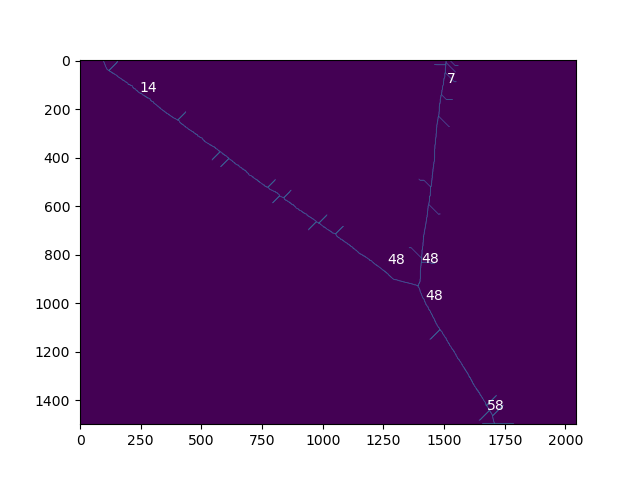

In [47]:
fig, ax = plt.subplots()
ax.imshow(skeletonized)
weight = 0.1
for edge in list(nx_graph_pruned.edges):
    ax.text(*np.flip((1-weight) * pos[edge[0]]+weight*pos[edge[1]]),str(edge[0]),color="white")
    ax.text(*np.flip((1-weight) * pos[edge[1]]+weight*pos[edge[0]]),str(edge[1]),color="white")

In [48]:
edges = [(14,48),(7,48),(58,48)]

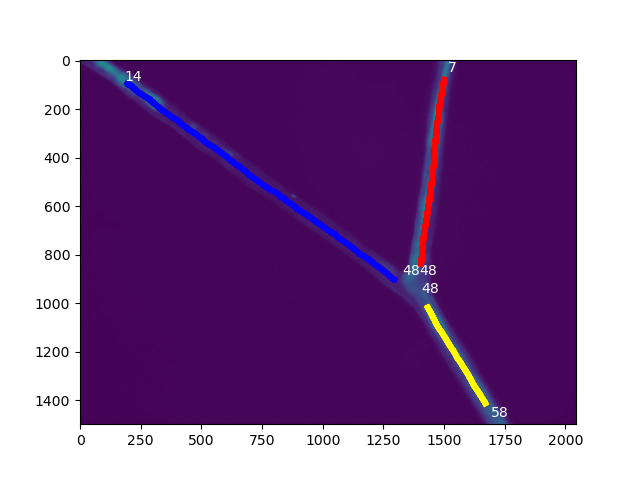

In [133]:
weight = 0.05

plt.close("all")
fig, ax = plt.subplots()
ax.imshow(mean_proj)
bound1 = 0
bound2 = 1
offset=90
step=30
target_length=10
resolution = 1
for j,edge in enumerate(edges):
    color = colors[j]

    slices, segments = extract_section_profiles_for_edge(
    edge,
    pos,
    image,
    nx_graph_pruned,
    resolution=resolution,
    offset=offset,
    step=step,
    target_length=target_length,
    bound1=bound1,
    bound2=bound2
)
    plot_segments_on_image(segments,ax)
    plot_segments_on_image(segments,ax,color = colors[j], bound1=bound1,
    bound2=bound2)
    
    ax.text(*np.flip((1-weight) * pos[edge[0]]+weight*pos[edge[1]]),str(edge[0]),color="white")
    ax.text(*np.flip((1-weight) * pos[edge[1]]+weight*pos[edge[0]]),str(edge[1]),color="white")
# save_path_temp = os.path.join(kymos_path, f"extraction.png")
# plt.savefig(save_path_temp)

In [51]:
kymos = {edge:get_kymo(edge,pos,selection_file,nx_graph_pruned) for edge in edges}

In [52]:
filtered_kymos = {edge: filter_kymo(kymos[edge]) for edge in kymos.keys()}


2023-02-10 15:27:45,105-[WARNING]- imageio:42 -> Lossy conversion from float64 to uint8. Range [8.3, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
2023-02-10 15:27:45,464-[WARNING]- imageio:42 -> Lossy conversion from float64 to uint8. Range [11.2, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
2023-02-10 15:27:45,585-[WARNING]- imageio:42 -> Lossy conversion from float64 to uint8. Range [13.9, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


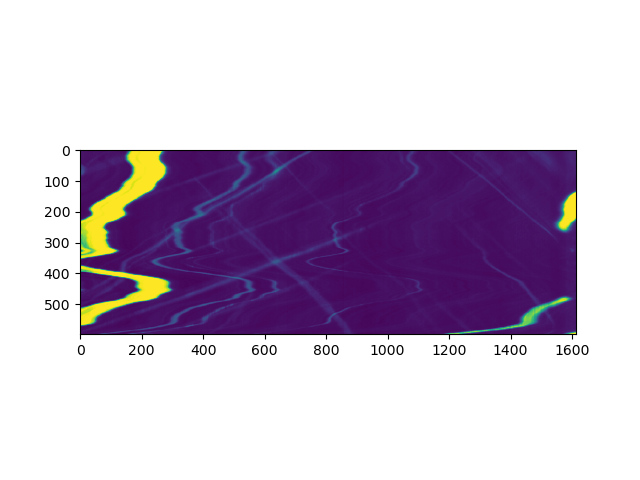

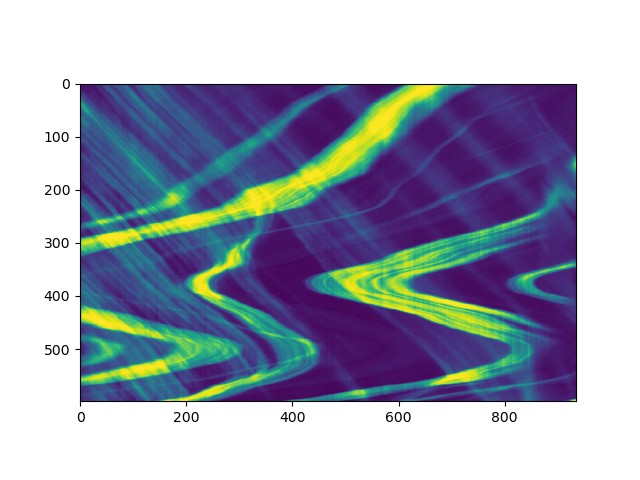

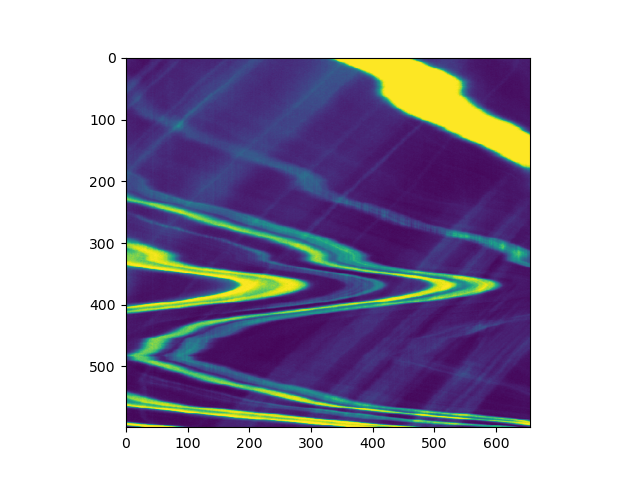

In [62]:
for edge in edges:
    fig,ax =plt.subplots()
    ax.imshow(kymos[edge])
    imageio.imsave(f'edge{edge}.png',kymos[edge])

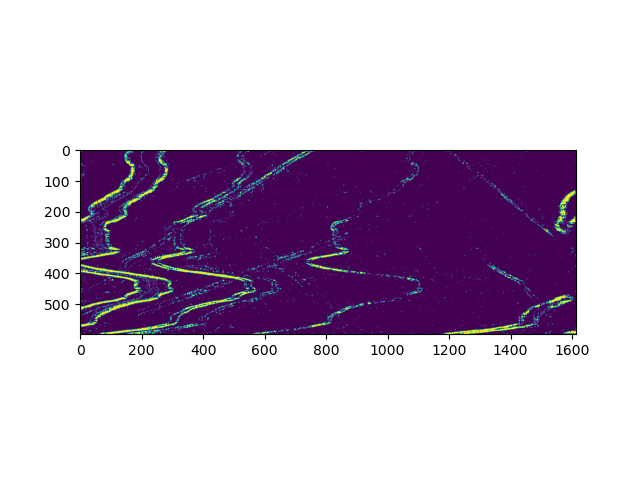

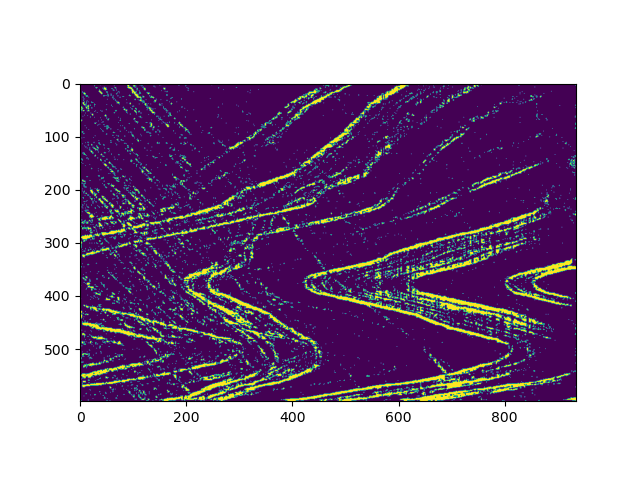

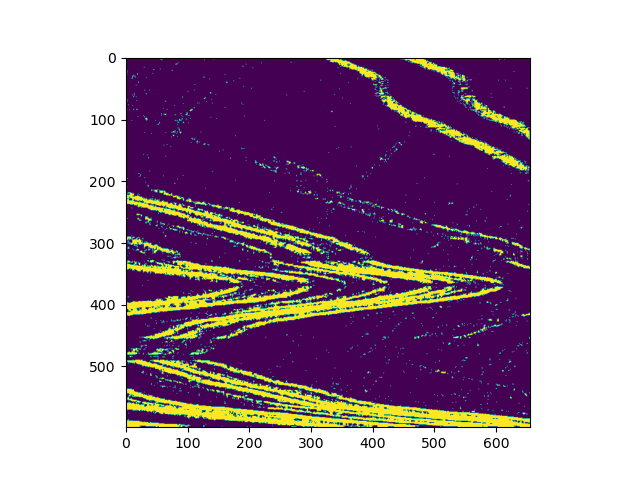

In [70]:
for j,edge in enumerate(kymos.keys()):
    fig,ax =plt.subplots()

    color = colors[j]
    # for i in [0,1]:
    kymo = kymos[edge]



    W = int(5/space_pixel_size)          # window size is WxW
    W = 3
    C_Thr = 0.95
    imgCoherency, imgOrientation = calcGST(kymo, W)
    ax.imshow(imgCoherency>C_Thr)

In [71]:
edges

[(14, 48), (7, 48), (58, 48)]

In [72]:
boundaries ={
(14, 48) : (0,600),
(7,48) : (500,830),
(58, 48) : (0,550),
}

C:\Users\coren\AppData\Local\Temp\ipykernel_7416\1180044284.py:36: RuntimeWarning: Mean of empty slice
  speeds = np.nanmean(speed,axis=1)
C:\Users\coren\anaconda3\envs\amftrack\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
C:\Users\coren\AppData\Local\Temp\ipykernel_7416\1180044284.py:36: RuntimeWarning: Mean of empty slice
  speeds = np.nanmean(speed,axis=1)
C:\Users\coren\anaconda3\envs\amftrack\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'd

2023-02-10 16:47:15,821-[WARNING]- matplotlib.legend:1236 -> No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


C:\Users\coren\AppData\Local\Temp\ipykernel_7416\1180044284.py:36: RuntimeWarning: Mean of empty slice
  speeds = np.nanmean(speed,axis=1)
C:\Users\coren\anaconda3\envs\amftrack\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


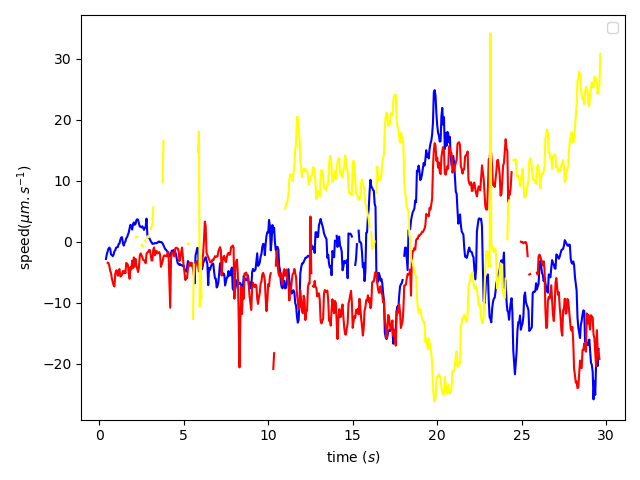

In [115]:
fig, ax = plt.subplots()
colors = ['blue','red','yellow','green','pink','orange','black','purple','brown','cyan','magenta']
speed_dataframe = pd.DataFrame()
for j,edge in enumerate(kymos.keys()):
    color = colors[j]
    # for i in [0,1]:
    bound = boundaries[edge]
    kymo = kymos[edge]



    W = int(5/space_pixel_size)          # window size is WxW
    W = 3
    C_Thr = 0.95
    imgCoherency, imgOrientation = calcGST(kymo, W)
    imgCoherency, imgOrientation = imgCoherency[:,bound[0]:bound[1]], imgOrientation[:,bound[0]:bound[1]]
    nans = np.empty(imgOrientation.shape)
    nans.fill(np.nan)
    real_movement = np.where(imgCoherency>C_Thr,imgOrientation,nans)
    speed=np.tan((real_movement-90)/180*np.pi)*space_pixel_size/time_pixel_size #um.s-1
    nans = np.empty(speed.shape)
    nans.fill(np.nan)
    speed = np.where(speed<40,speed,nans)
    nans = np.empty(speed.shape)
    nans.fill(np.nan)
    speed = np.where(speed>-40,speed,nans)
    # ax.imshow((imgCoherency))
    klen = 25
    kernel = np.ones((klen,klen))/klen**2
    z1 = scipy.signal.convolve2d(imgCoherency, kernel,mode = "same")
    nans = np.empty(speed.shape)
    nans.fill(np.nan)
    speed = np.where(z1>0.7,speed,nans)
    label =edge if i==0 else None
    times = np.array(range(len(np.mean(speed,axis=1))))*time_pixel_size
    speeds = np.nanmean(speed,axis=1)
    edges_list = [edge for k in range(len(speeds))]
    data = pd.DataFrame(np.transpose((times,speeds,edges_list)),
                 columns = ['time (s)','speed (um.s-1)','edge'])
    speed_dataframe = pd.concat((speed_dataframe,data))
    ax.plot(times,speeds,label =edge if i==0 else None,color = color)
    ax.set_ylabel('speed($\mu m.s^{-1}$)')
    ax.set_xlabel('time ($s$)')
# save_path_temp = os.path.join(kymos_path, f"speed_data.csv")
# speed_dataframe.to_csv(save_path_temp)
plt.legend()
plt.tight_layout()

In [129]:
edges

[(14, 48), (7, 48), (58, 48)]

In [81]:
speeds0 = speed_dataframe.loc[speed_dataframe['edge'] == (14,48)]
speeds1 = speed_dataframe.loc[speed_dataframe['edge'] == (7,48)]
speeds2 = speed_dataframe.loc[speed_dataframe['edge'] == (58,48)]

In [125]:
speeds0['speed_smooth']=speeds0['speed (um.s-1)'].rolling(10,min_periods = 2).median()
speeds1['speed_smooth']=speeds1['speed (um.s-1)'].rolling(10,min_periods = 2).median()
speeds2['speed_smooth']=speeds2['speed (um.s-1)'].rolling(10,min_periods = 2).median()

C:\Users\coren\AppData\Local\Temp\ipykernel_7416\2652461231.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speeds0['speed_smooth']=speeds0['speed (um.s-1)'].rolling(10,min_periods = 2).median()
C:\Users\coren\AppData\Local\Temp\ipykernel_7416\2652461231.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speeds1['speed_smooth']=speeds1['speed (um.s-1)'].rolling(10,min_periods = 2).median()
C:\Users\coren\AppData\Local\Temp\ipykernel_7416\2652461231.py:3: SettingWithCopyWarning: 
A value is trying to be

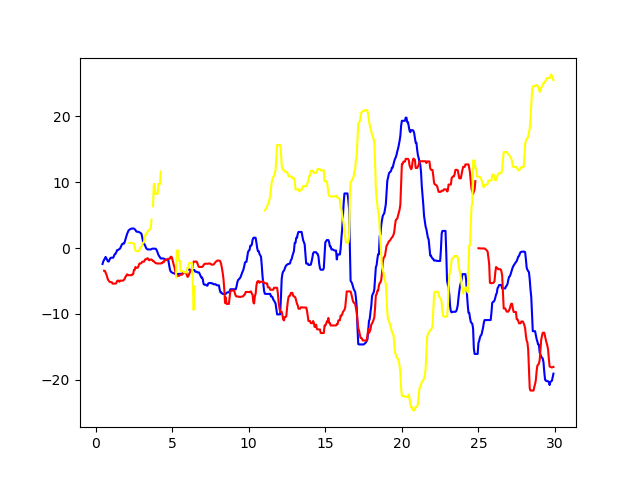

In [130]:
fig, ax = plt.subplots()
ax.plot(speeds0['time (s)'],speeds0['speed_smooth'],colors[0])
ax.plot(speeds1['time (s)'],speeds1['speed_smooth'],colors[1])
ax.plot(speeds2['time (s)'],speeds2['speed_smooth'],colors[2])

In [91]:
ratios_b = ratios_b.loc[ratios_b.between(-10,10)]

Text(0, 0.5, 'speed (58,48)/speed (14,48)')

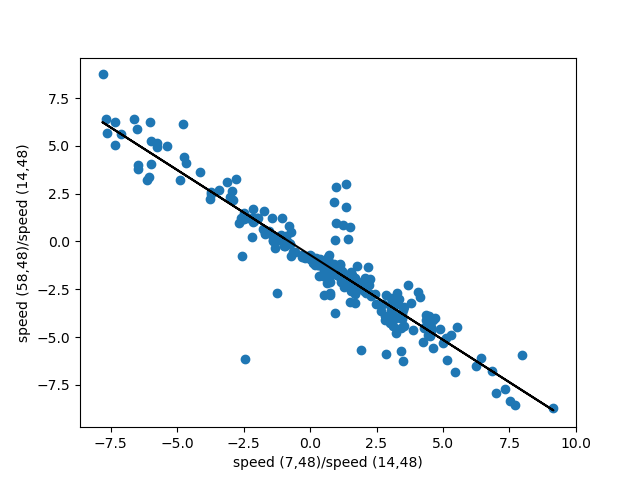

In [117]:
ratios_a = speeds1['speed (um.s-1)']/speeds0['speed (um.s-1)']
ratios_b = speeds2['speed (um.s-1)']/speeds0['speed (um.s-1)']
ratios_a = ratios_a.loc[ratios_b.between(-10,10)]
ratios_b = ratios_b.loc[ratios_b.between(-10,10)]
ratios_b = ratios_b.loc[ratios_a.between(-10,10)]
ratios_a = ratios_a.loc[ratios_a.between(-10,10)]
# ratios_b = ratios_b.loc[ratios_a.between(-10,10)]
fig, ax = plt.subplots()
ax.scatter(ratios_a,ratios_b)
ax.plot(x0,np.array(x0)*a+b,color = 'black')
ax.set_xlabel('speed (7,48)/speed (14,48)')
ax.set_ylabel('speed (58,48)/speed (14,48)')

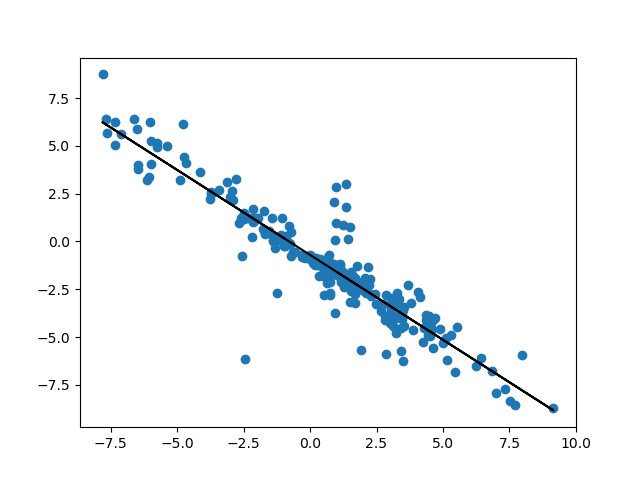

In [106]:
import statsmodels.api as sm

x = ratios_a.values.astype(float)
y = ratios_b.values.astype(float)
x0 = x
X = sm.add_constant(x, prepend=False)
model = sm.OLS(y,X)
res = model.fit()
a,b = res.params[0],res.params[1]
fig, ax = plt.subplots()
ax.scatter(x,y)
ax.plot(x0,np.array(x0)*a+b,color = 'black')

In [110]:
r0 = np.median([86,86,84,82,85])*space_pixel_size
r1 = np.median([82,86,77,80,85])*space_pixel_size
r2 = np.median([107,102,103])*space_pixel_size

In [112]:
a,b

(-0.8886732859599186, -0.6986306297779361)

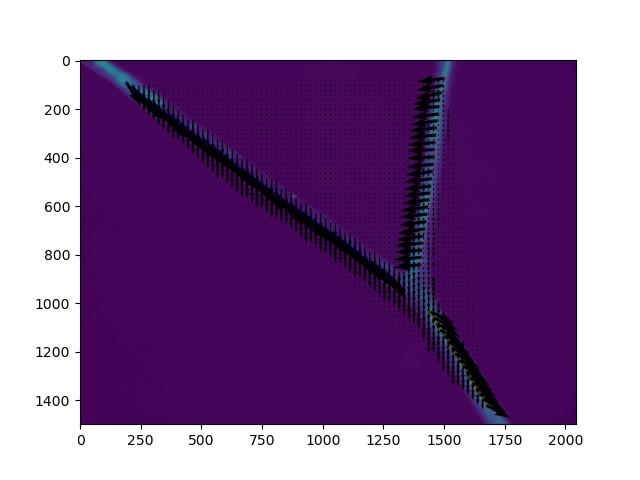

In [194]:
weight = 0.05

plt.close("all")
fig, ax = plt.subplots()
ax.imshow(mean_proj)
bound1 = 0
bound2 = 1
offset=90
step=30
target_length=10
resolution = 30
xs=[]
ys=[]
us=[]
vs=[]
for j,edge in enumerate(edges):
    color = colors[j]
    slices, segments = extract_section_profiles_for_edge(
    edge,
    pos,
    image,
    nx_graph_pruned,
    resolution=resolution,
    offset=offset,
    step=step,
    target_length=target_length,
    bound1=bound1,
    bound2=bound2
)
    # plot_segments_on_image(segments,ax)
    plot_segments_on_image(segments,ax,color = colors[j], bound1=bound1,
    bound2=bound2,alpha= 0.2)
    for segment in segments:
        x = int(np.array(segment)[:,0].mean())
        y = int(np.array(segment)[:,1].mean())
        vec = segment[1]-segment[0]
        u =vec[1]
        v = vec[0]
        xs.append(x)
        ys.append(y)
        us.append(u)
        vs.append(v)
xx = np.linspace(0, mean_proj.shape[0]-1, mean_proj.shape[0]//20)
yy = np.linspace(0, mean_proj.shape[1]-1, mean_proj.shape[1]//20)
xx, yy = np.meshgrid(xx, yy)

points = np.transpose(np.vstack((xs, ys)))
u_interp = interpolate.griddata(points, us, (xx, yy), method='linear')
u_inter = u_interp*connected[xx.astype(int),yy.astype(int)]
v_interp = interpolate.griddata(points, vs, (xx, yy), method='linear')
v_interp = v_interp*connected[xx.astype(int),yy.astype(int)]
ax.quiver(yy, xx, u_interp, v_interp)
ax.quiver(ys, xs, us, vs)

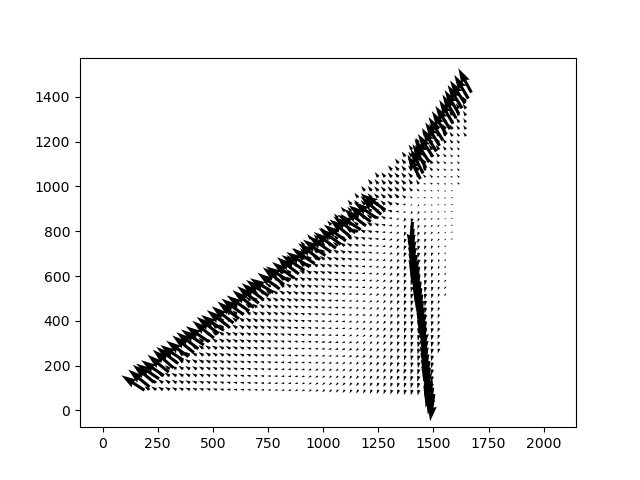

In [189]:
fig,ax = plt.subplots()
ax.quiver(ys, xs, us, vs)
xx = np.linspace(0, mean_proj.shape[0], mean_proj.shape[0]//30)
yy = np.linspace(0, mean_proj.shape[1], mean_proj.shape[1]//30)
xx, yy = np.meshgrid(xx, yy)

points = np.transpose(np.vstack((xs, ys)))
u_interp = interpolate.griddata(points, us, (xx, yy), method='linear')*5
# u_inter
v_interp = interpolate.griddata(points, vs, (xx, yy), method='linear')*5
ax.quiver(yy, xx, u_interp, v_interp)


In [166]:
u_interp

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [151]:
x = int(np.array(segments[0])[:,0].mean())
y = int(np.array(segments[0])[:,1].mean())
vec = segments[0][1]-segments[0][0]
u =vec[0]
v = vec[1]